# Detection of Cardiac Arrhythmia
## Rahul Kumar Goyal

### Table of Contents
**1.** Load Libraies<br>
**2.** Load Data<br>
**3.** Data Cleaning and Transformation <br>
&nbsp;&nbsp;&nbsp; 3.1 Renaming Columns <br>
   &nbsp;&nbsp;&nbsp; 3.2 Missing Data Imputation <br>
   &nbsp;&nbsp;&nbsp; 3.3 Column Dropping <br>
**4.** Exploratory Analysis<br>
&nbsp;&nbsp;&nbsp;4.1 Histograms for Numeric Variables<br>
&nbsp;&nbsp;&nbsp;4.2 Pie Charts for Categoric Variables<br>
&nbsp;&nbsp;&nbsp;4.3 Correlation Plot <br> 
&nbsp;&nbsp;&nbsp;4.4 Histograms by Target Class<br>
**5.** Modeling<br>
  &nbsp;&nbsp;&nbsp;  5.1 Train Test Splits<br>
   &nbsp;&nbsp;&nbsp; 5.2 Baseline Model<br>
   &nbsp;&nbsp;&nbsp; 5.3 Feature Selection<br>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.1 Univariate Feature Elimination<br>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.2 Recursive Feature Elimination<br>
   &nbsp;&nbsp;&nbsp; 5.4 Grid Search and Cross Validation<br>
**6.** Final Model Results<br>

### 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # to show plots in notebook

from utilities import *
from scipy import interp

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn import pipeline

from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn import linear_model, decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings; warnings.simplefilter('ignore')

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



### 2. Load Data

In [2]:
df = pd.read_csv('cardiac_arrhythmia.csv', header=None, na_values=['?'])
df.head()

0    1    2    3    4    5    6    7    8    9   ...   270   271  272  273  \
0   75    0  190   80   91  193  371  174  121  -16 ...   0.0   9.0 -0.9  0.0   
1   56    1  165   64   81  174  401  149   39   25 ...   0.0   8.5  0.0  0.0   
2   54    0  172   95  138  163  386  185  102   96 ...   0.0   9.5 -2.4  0.0   
3   55    0  175   94  100  202  380  179  143   28 ...   0.0  12.2 -2.2  0.0   
4   75    0  190   80   88  181  360  177  103  -16 ...   0.0  13.1 -3.6  0.0   

   274  275  276   277   278  279  
0    0  0.9  2.9  23.3  49.4    8  
1    0  0.2  2.1  20.4  38.8    6  
2    0  0.3  3.4  12.3  49.0   10  
3    0  0.4  2.6  34.6  61.6    1  
4    0 -0.1  3.9  25.4  62.8    7  

[5 rows x 280 columns]

### 3. Data Cleaning and Transformation

#### 3.1 Renaming Columns

As we can see above, the dataset does not have column names. Using the metadata document, add column names to the dataframe

In [3]:
## As there are lot of columns break into different categories and append to the colnames list
# 1) General subject attributes, Depolarization and repolarization attributes
colnames = ["Age", "Gender", "Height", "Weight", "QRS_Duration", "PR_Interval",
           "QT_Interval","T_Interval","P_Interval"]

# 2) Vector angles different waves
for name in ["QRS","T","P","QRST","J"]:
    colnames.append("VectorAngle_"+name)

# 3) Number of heart beats per minute
colnames.append("HeartRate")

# 4) Waves' widths; Number of intrinstic deflections; Existence of ragged
# or diphasic derivation of R,P and T waves; Wave Amplitudes;
# Area under the QRS complex (normal and including T wave).
# These attributes are present for every electrode channel

channels = ["DI","DII","DIII","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]
channel_specs_1 = ["QWidth","RWidth","SWidth","RPWidth","SPWidth","NumDeflections",
                 "ExistRagR","ExistDiaR","ExistRagP","ExistDiaP","ExistRagT","ExistDiaT"]
channel_specs_2 = ["AmpJJ","AmpQ","AmpR","AmpS","AmpRP",
                 "AmpSP","AmpP","AmpT","QRSA","QRSTA"]

for channel in channels:
    for spec in channel_specs_1:
        colnames.append(channel+"_"+spec)

for channel in channels:
    for spec in channel_specs_2:
        colnames.append(channel+"_"+spec)

# 5) Target column - Class of Cardia Arrhythmia
colnames.append("Target")

## Seperate Nominal and Linear columns for future use
# Nominal columns
channel_spec = ["ExistRagR","ExistDiaR","ExistRagP","ExistDiaP","ExistRagT","ExistDiaT"]
channels = ["DI","DII","DIII","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]

NominalCols = ["Gender"]
for channel in channels:
    for spec in channel_spec:
        NominalCols.append(channel+"_"+spec)

# Linear Columns
LinearCols = [i for i in colnames if i not in NominalCols]
LinearCols = LinearCols[:-1] #Remove the "Target" column from LinearCols

Now rename the dataframe using the 'colnames' list

In [4]:
df.columns = colnames
df.head(2)

Age  Gender  Height  Weight  QRS_Duration  PR_Interval  QT_Interval  \
0   75       0     190      80            91          193          371   
1   56       1     165      64            81          174          401   

   T_Interval  P_Interval  VectorAngle_QRS   ...    V6_AmpQ  V6_AmpR  V6_AmpS  \
0         174         121              -16   ...        0.0      9.0     -0.9   
1         149          39               25   ...        0.0      8.5      0.0   

   V6_AmpRP  V6_AmpSP  V6_AmpP  V6_AmpT  V6_QRSA  V6_QRSTA  Target  
0       0.0         0      0.9      2.9     23.3      49.4       8  
1       0.0         0      0.2      2.1     20.4      38.8       6  

[2 rows x 280 columns]

#### 3.2 Missing values imputation

Get columns where there are more than 0 missing values and plot them

Text(0.5,1,'Percentage of missing values')

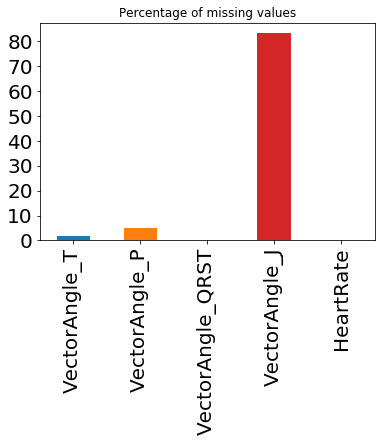

In [5]:
missing_values=100*df.isnull().sum()/df.shape[0]
missing_values=missing_values[missing_values != 0]

axes=missing_values.plot.bar(fontsize=20)
axes.set_title('Percentage of missing values')

Plot the distributions of these 5 variables as shown in the plot above

In [6]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for col in missing_values.index.values:
    fig.add_trace(
        go.Histogram(x=df[col], name=col)
    )

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
        label=list(missing_values.index.values)[i]
    )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": ""},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    yaxis=dict(
        title='#samples',
        automargin=True,
    )
)

fig.show()

VectorAngle_J has too many missing values and the distribution is not normal to impute. So remove this column.
For other columns just impute the data with median

In [7]:
# Drop Vector Angle J
df.drop('VectorAngle_J', inplace=True, axis=1)
missing_values.drop('VectorAngle_J', inplace=True)
colnames.remove('VectorAngle_J')
LinearCols.remove('VectorAngle_J')

# Impute with median
df = df.fillna(df.median())

#### 3.3 Column dropping

Check to see if any columns have not more than 1 unique value. If there is only one unique value, we might want to remove that because they have 0 variance.

In [8]:
# Nominal columns
print('Nominal Columns')
for col in NominalCols:
    if len(df[col].unique()) != 2:
        print("Number of of Unique values in the column '"+col+"' column are: ",end="")
        print(len(df[col].unique()))
        
# Linear columns
print('Linear Columns')
for col in LinearCols:
    if len(df[col].unique()) == 1:
        print("Number of of Unique values in the column '"+col+"' column are: ",end="")
        print(len(df[col].unique()))

Nominal Columns
Number of of Unique values in the column 'AVL_ExistRagR' column are: 1
Number of of Unique values in the column 'AVF_ExistRagP' column are: 1
Number of of Unique values in the column 'V4_ExistRagP' column are: 1
Number of of Unique values in the column 'V4_ExistDiaP' column are: 1
Number of of Unique values in the column 'V5_ExistRagR' column are: 1
Number of of Unique values in the column 'V5_ExistRagP' column are: 1
Number of of Unique values in the column 'V5_ExistRagT' column are: 1
Number of of Unique values in the column 'V6_ExistDiaP' column are: 1
Number of of Unique values in the column 'V6_ExistRagT' column are: 1
Linear Columns
Number of of Unique values in the column 'DI_SPWidth' column are: 1
Number of of Unique values in the column 'AVL_SPWidth' column are: 1
Number of of Unique values in the column 'V5_SPWidth' column are: 1
Number of of Unique values in the column 'V6_SPWidth' column are: 1
Number of of Unique values in the column 'DI_AmpSP' column are: 

In [9]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)

#Update the nominal and linear columns list
NominalCols = [i for i in NominalCols if i in df.columns]
LinearCols = [i for i in LinearCols if i in df.columns]
colnames = [i for i in colnames if i in df.columns]

Create a Binary Target variable of having vs not having Caridac Arrhythmia for visualization

In [10]:
# Binary
df['Target_Binary']=df['Target'].apply(lambda x:0 if x==1 else 1)
df['Target_Binary'].value_counts()

# Target reclassification
df['Target']=df['Target'].apply(lambda x:x if x in [1,2,10] else 15)
df['Target'].value_counts()

1     245
15    113
10     50
2      44
Name: Target, dtype: int64

### 4. Exploratory Data Analysis

#### 4.1 Histograms for Numeric Variables

1. Generic Variables

In [11]:
cols_to_plot = ['Age','Height','Weight','HeartRate']
plot_hists(df, cols_to_plot)

In [12]:
df[df.Height > 200]

Age  Gender  Height  Weight  QRS_Duration  PR_Interval  QT_Interval  \
141    1       1     780       6            85          165          237   
316    0       0     608      10            83          126          232   

     T_Interval  P_Interval  VectorAngle_QRS      ...        V6_AmpQ  V6_AmpR  \
141         150         106               88      ...            0.0      5.0   
316         128          60              125      ...           -0.7      4.5   

     V6_AmpS  V6_AmpRP  V6_AmpP  V6_AmpT  V6_QRSA  V6_QRSTA  Target  \
141     -4.6       0.0      1.3      0.7      2.7       5.5      15   
316     -5.5       0.0      0.5      2.5    -11.8       1.7      15   

     Target_Binary  
141              1  
316              1  

[2 rows x 263 columns]

Age is 1 and 0. So, height cannot be 780 and 608. So, dividing them by 10 which is the normal height of infants

In [13]:
df.loc[df.Height > 200, 'Height'] = df.loc[df.Height > 200, 'Height']/10

2. Polarization and Depolarization Intervals. Vector Angles.

In [14]:
cols_to_plot=["QRS_Duration", "PR_Interval","QT_Interval","T_Interval","P_Interval"]

for name in ["QRS","T","P","QRST","J"]:
    cols_to_plot.append("VectorAngle_"+name)

cols_to_plot.remove('VectorAngle_J')

plot_hists(df, cols_to_plot)

3. Wave characteristics by channels

In [15]:
cols_to_plot=[]

cols_to_plot=['QRS_Duration', 'VectorAngle_QRST', 'HeartRate', 'AVF_QWidth',
 'V3_QWidth', 'AVR_AmpT', 'AVL_QRSA', 'AVF_QRSA', 'V1_AmpJJ',
 'V1_AmpRP', 'V2_AmpT', 'V2_QRSA', 'V2_QRSTA', 'V3_AmpT', 'V4_AmpJJ']

channels = ["DI","DII","DIII","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]
channel_specs_1 = ["QWidth","RWidth","SWidth","RPWidth","SPWidth","NumDeflections"]
channel_specs_2 = ["AmpJJ","AmpQ","AmpR","AmpS","AmpRP",
                 "AmpSP","AmpP","AmpT","QRSA","QRSTA"]

for channel in channels:
    for spec in channel_specs_1:
        cols_to_plot.append(channel+"_"+spec)

for channel in channels:
    for spec in channel_specs_2:
        cols_to_plot.append(channel+"_"+spec)
        
plot_hists(df, cols_to_plot)

#### 4.2 Pie Charts for Categorical Variables

In [16]:
for col in NominalCols:
    plot_pie(column=col, df=df)

Remove columns which are populated by zeros for 2 or more classes

In [17]:
NominalCols2=NominalCols+['Target']

count_zeros_by_target = df[NominalCols2].groupby('Target').agg(lambda x: x.eq(0).sum())
count_zeros_by_target['Target'] = df['Target'].value_counts()

count_1_ratio=count_zeros_by_target.iloc[:,:-1].div(count_zeros_by_target.Target, axis=0)
remove_nominal_columns=count_1_ratio.columns[(count_1_ratio==1).sum() >= 2]
print(remove_nominal_columns)
print(len(remove_nominal_columns))

Index(['DI_ExistRagR', 'DI_ExistDiaR', 'DI_ExistRagP', 'DI_ExistDiaP',
       'DI_ExistRagT', 'DI_ExistDiaT', 'DII_ExistRagP', 'DII_ExistDiaP',
       'DII_ExistRagT', 'DIII_ExistRagR', 'DIII_ExistRagP', 'DIII_ExistDiaP',
       'DIII_ExistDiaT', 'AVR_ExistRagR', 'AVR_ExistDiaR', 'AVR_ExistRagP',
       'AVR_ExistDiaP', 'AVR_ExistRagT', 'AVR_ExistDiaT', 'AVL_ExistRagP',
       'AVL_ExistDiaP', 'AVL_ExistRagT', 'AVL_ExistDiaT', 'AVF_ExistRagR',
       'AVF_ExistDiaP', 'AVF_ExistRagT', 'AVF_ExistDiaT', 'V1_ExistRagR',
       'V1_ExistDiaR', 'V2_ExistDiaR', 'V2_ExistDiaP', 'V2_ExistRagT',
       'V3_ExistDiaR', 'V3_ExistRagP', 'V3_ExistDiaP', 'V3_ExistRagT',
       'V3_ExistDiaT', 'V4_ExistRagR', 'V4_ExistRagT', 'V5_ExistDiaR',
       'V5_ExistDiaP', 'V5_ExistDiaT', 'V6_ExistRagR', 'V6_ExistDiaR',
       'V6_ExistRagP', 'V6_ExistDiaT'],
      dtype='object')
46


In [18]:
for col in df.columns:
    if col in remove_nominal_columns:
        df.drop(col, inplace=True, axis=1)

#Update the nominal and linear columns list
NominalCols = [i for i in NominalCols if i in df.columns]
LinearCols = [i for i in LinearCols if i in df.columns]
colnames = [i for i in colnames if i in df.columns]

#### 4.3 Correlation Plot

The correlation plot indicates that there is not a lot of correlation between variables

In [19]:
corr = df.corr()
trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
data=[trace]
layout = go.Layout(
    title='Heatmap of pairwise correlation of the columns',
    autosize=False,
    width=850,
    height=700,
    yaxis=go.layout.YAxis(automargin=True),
    xaxis=dict(tickangle=40),
    margin=go.layout.Margin(l=0, r=200, b=200, t=80)
)


fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap1')

#### 4.4 Histograms broken down by Target Class for Generic Numeric Variables

In [20]:
disease = df[df["Target_Binary"] == 1]
no_disease = df[df["Target_Binary"] == 0]

In [21]:
cols_to_plot = ['Age','Height','Weight','HeartRate']
plot_hists2(disease, no_disease, cols_to_plot)

### 5. Modeling

#### 5.1 Train Test Split and Rescaling variables

In [22]:
train_cols=list(df.columns.values)
train_cols.remove('Target')
train_cols.remove('Target_Binary')

In [23]:
# 01 - Normal 245
# 15 - Others 113
# 10 - Right bundle branch block 50
# 2 - Coronary Artery Disease 44
df['Target'].value_counts()

1     245
15    113
10     50
2      44
Name: Target, dtype: int64

In [24]:
X = df[train_cols]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.fit_transform(X)

In [25]:
print(y_train.value_counts())
print(y_test.value_counts())

1     171
15     79
10     35
2      31
Name: Target, dtype: int64
1     74
15    34
10    15
2     13
Name: Target, dtype: int64


Target Class distribution Plot

In [26]:
#labels
lab = ['No Disease', 'Other', 'Right Bundle Branck Block', 'Coronary Artery Disease']
#values
val = df["Target"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(line = dict(color = "white",
                                         width =  1.3)),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Cardiac Arrhythmia Class Distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
fig.update_traces(marker = dict(colors = ['green', 'rgb(255,0,0)', 'rgb(200,0,0)', 'rgb(150,0,0)']))
fig.update_layout(font=dict(size=22))

iplot(fig)

#### 5.2 Baseline model: Logistic Regression

Grid Search

In [27]:
param_grid = {'C':[0.1,0.5,1,2,5,10]}

for multi_class in ('multinomial', 'ovr'):
    grid_search = GridSearchCV(linear_model.LogisticRegression(solver='sag', random_state=1, multi_class=multi_class),
                               param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

    grid_search.fit(X_train_scaled, y_train)
    
    print(multi_class)
    print_grid_search(grid_search)

multinomial
Best parameters: {'C': 1}
Best cross-validation score: 0.70
Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
ovr
Best parameters: {'C': 2}
Best cross-validation score: 0.69
Best estimator:
LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)


Select from Multinomial or OVR

In [28]:
for multi_class, c in [('multinomial',1), ('ovr', 2)]:
    clf = linear_model.LogisticRegression(solver='sag', random_state=1, C = c,
                             multi_class=multi_class).fit(X_train_scaled, y_train)

    # print the training scores
    print(multi_class)
    print_model_scores(model = clf, X_test_scaled=X_test_scaled, 
                       X_train_scaled=X_train_scaled, y_test=y_test, y_train=y_train)

multinomial
Train Accuracy : 0.8481 
Test Accuracy : 0.7132 
Confusion matrix Train: 
[[168   0   1   2]
 [ 10  21   0   0]
 [  5   0  30   0]
 [ 28   1   1  49]]
Confusion matrix Test: 
[[68  0  0  6]
 [ 6  6  0  1]
 [ 6  1  7  1]
 [13  4  1 16]]
AUC Train: 0.9634
AUC Test: 0.8459


ovr
Train Accuracy : 0.8449 
Test Accuracy : 0.7206 
Confusion matrix Train: 
[[168   0   1   2]
 [ 10  21   0   0]
 [  6   0  29   0]
 [ 28   1   1  49]]
Confusion matrix Test: 
[[69  0  0  5]
 [ 6  6  0  1]
 [ 6  1  7  1]
 [13  4  1 16]]
AUC Train: 0.9650
AUC Test: 0.8511




Fit and Plot the Model results

In [29]:
def plot_model(X_train_scaled, y_train, X_test_scaled, y_test, clf):
    
    y_predicted = clf.predict(X_test_scaled)
    y_train_preds = clf.predict(X_train_scaled)
    
    unique_classes=[1,2,10,15]

    probabilities = clf.predict_proba(X_test_scaled)

    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=[1,2,10,15])
    n_classes = y_test_binarized.shape[1]

    print (clf)
    print ("\n Classification report : \n",classification_report(y_test,y_predicted))
    print("Test Accuracy   Score : {:.4f}".format(accuracy_score(y_test,y_predicted)))
    
    #confusion matrix
    conf_matrix = confusion_matrix(y_test,y_predicted)    
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    ## Calculate MultiClass AUC
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    print("Multi-Class Area Under the Curve: {:.4f}".format(roc_auc['macro']))
    print ("\n")

    print('Classwise Area Under the Curves')
    for i in range(len(unique_classes)):
        if i==0:
            auc_name = 'Normal- '
        else:
            auc_name = 'Disease Type '+str(i) + '- '
        
        temp_auc = round(roc_auc[i], 2)
        print(auc_name + str(temp_auc))
    print('\n')
    
    #plot confusion matrix
    trace1 = ff.create_annotated_heatmap(conf_matrix,
                                         x = ["No Arrhythmia", 'Other', 'Right Bundle Branch Block', 
                                              'Coronary Artery Disease'],
                                         y = ["No Arrhythmia", 'Other', 'Right Bundle Branch Block',
                                              'Coronary Artery Disease'],
                                         colorscale = 'Picnic')
    # Make text size smaller
    for i in range(len(trace1.layout.annotations)):
        trace1.layout.annotations[i].font.size = 25
    
    trace1['layout'].update(plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)')
    
    trace1.show()
    #subplots
    fig = tls.make_subplots(rows=2, cols=2,
                            specs=[ [{}, {}], [{}, {}]],
                                subplot_titles=('ROC 1',
                                                'ROC 2',
                                                'ROC 3',
                                                'ROC 4'))

    for i in range(n_classes):
        trace2_temp = go.Scatter(x = fpr[i],y = tpr[i],
                                 name = "Roc : " + str(roc_auc[i]), 
                                 mode='lines+text',
                                 text=['AUC: '+str(round(roc_auc[i], 2))], 
                                 textposition='top right',
                                 textfont=dict(
                                     family="sans serif",
                                     size=18,
                                     color="DarkSeaGreen"),
                                 line = dict(color = ('rgb(22, 96, 167)'),
                                             width = 2))
        trace3_temp = go.Scatter(x = [0,1],y=[0,1],
                                 line = dict(color = ('rgb(205, 12, 24)'),
                                             width = 2,
                                             dash = 'dot'))
        if i==0:
            fig.append_trace(trace2_temp,1,1)
            fig.append_trace(trace3_temp,1,1)
        elif i==1:
            fig.append_trace(trace2_temp,1,2)
            fig.append_trace(trace3_temp,1,2)
        elif i==2:
            fig.append_trace(trace2_temp,2,1)
            fig.append_trace(trace3_temp,2,1)
        else:
            fig.append_trace(trace2_temp,2,2)
            fig.append_trace(trace3_temp,2,2)

    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    for i in [1,2,3,4]:
        fig["layout"]["xaxis"+str(i)].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis"+str(i)].update(dict(title = "true positive rate"))

    iplot(fig)

In [30]:
clf = linear_model.LogisticRegression(C=2, class_weight=None, dual=False,
                                                fit_intercept=True,
              intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
              penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
              verbose=0, warm_start=False).fit(X_train_scaled, y_train)

print("Train Accuracy   Score : {:.4f}".format(accuracy_score(y_train,
                                                              clf.predict(X_train_scaled))))

print_model_scores(X_test_scaled=X_test_scaled,
           X_train_scaled=X_train_scaled,
           model=clf,
           y_test=y_test,
           y_train=y_train)

plot_model(X_test_scaled=X_test_scaled,
           X_train_scaled=X_train_scaled,
           clf=clf,
           y_test=y_test,
           y_train=y_train)

Train Accuracy   Score : 0.8449
Train Accuracy : 0.8449 
Test Accuracy : 0.7206 
Confusion matrix Train: 
[[168   0   1   2]
 [ 10  21   0   0]
 [  6   0  29   0]
 [ 28   1   1  49]]
Confusion matrix Test: 
[[69  0  0  5]
 [ 6  6  0  1]
 [ 6  1  7  1]
 [13  4  1 16]]
AUC Train: 0.9657
AUC Test: 0.8504


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           1       0.73      0.93      0.82        74
           2       0.55      0.46      0.50        13
          10       0.88      0.47      0.61        15
          15       0.70      0.47      0.56        34

    accuracy                           0.72       136
   macro avg       0.71      0.58   

#### 5.3 Feature Elimination

##### 5.3.1 Univariate Feature Elimination

In [31]:
#dataframe with non negative values
df_x = X_train_scaled
df_y = y_train

cols = X.columns.values

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 10)
fit    = select.fit(df_x,df_y)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(LinearCols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1.5)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [32]:
num_feats=score[score.feature_type=='Numerical']['features'][:5].tolist()
cat_feats=score[score.feature_type=='Categorical']['features'][:10].tolist()

all_feats=num_feats+cat_feats

X1 = df[all_feats]
y1 = df['Target']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify = y1)

scaler1 = MinMaxScaler()

X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)

X_scaled1 = scaler.fit_transform(X1)

clf = linear_model.LogisticRegression(solver='sag', random_state=1, C = 1,
                             multi_class='multinomial').fit(X_train_scaled1, y_train1)

plot_model(X_test_scaled=X_test_scaled1,
           X_train_scaled=X_train_scaled1,
           clf=clf,
           y_test=y_test1,
           y_train=y_train1)

print_model_scores(X_test_scaled=X_test_scaled1,
           X_train_scaled=X_train_scaled1,
           model=clf,
           y_test=y_test1,
           y_train=y_train1)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           1       0.61      0.96      0.75        74
           2       0.00      0.00      0.00        13
          10       0.86      0.40      0.55        15
          15       0.62      0.24      0.34        34

    accuracy                           0.62       136
   macro avg       0.52      0.40      0.41       136
weighted avg       0.58      0.62      0.55       136

Test Accuracy   Score : 0.6250
Multi-Class Area Under the Curve: 0.7187


Classwise Area Under the Curves
Normal- 0.72
Disease Type 1- 0.59
Disease Type 2- 0.85
Disease Type 3- 0.7




Train Accuracy : 0.6772 
Test Accuracy : 0.6250 
Confusion matrix Train: 
[[166   0   1   4]
 [ 28   1   1   1]
 [ 16   0  19   0]
 [ 48   0   3  28]]
Confusion matrix Test: 
[[71  0  0  3]
 [12  0  0  1]
 [ 8  0  6  1]
 [25  0  1  8]]
AUC Train: 0.7518
AUC Test: 0.7187




{'Test_Accuracy': 0.625,
 'Train_Accuracy': 0.6772,
 'Train AUC': 0.7518,
 'Test AUC': 0.7187}

##### 5.3.2 Recursive Feature Elimination

In [33]:
scores_temp = []
for num_cols in np.arange(5,50):

    logit = linear_model.LogisticRegression(C=1, class_weight=None, dual=False,
                                            fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

    rfe = RFE(logit,num_cols)
    rfe = rfe.fit(X_train_scaled,y_train)

    rfe.support_
    rfe.ranking_

    #identified columns Recursive Feature Elimination
    idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                           "columns" : X_train.columns.values,
                           "ranking" : rfe.ranking_,
                          })
    cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
    #print(cols)

    #separating train and test data
    train_rf_X = X_train[cols]
    train_rf_Y = y_train
    test_rf_X  = X_test[cols]
    test_rf_Y  = y_test

    logit_rfe = linear_model.LogisticRegression(C=1, class_weight=None, dual=False,
                                            fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    
    #logit_rfe=DecisionTreeClassifier(max_depth=20)
    logit_rfe.fit(train_rf_X, train_rf_Y)
    
    probabilities = logit_rfe.predict_proba(test_rf_X)
    
    # Binarize the output
    y_test_binarized = label_binarize(test_rf_Y, classes=[1,2,10,15])
    n_classes = y_test_binarized.shape[1]
    
    print("Train Accuracy   Score : {:.4f}".format(accuracy_score(train_rf_Y,
                                                                 logit_rfe.predict(train_rf_X))))
    print("Test Accuracy   Score : {:.4f}".format(accuracy_score(test_rf_Y,
                                                                 logit_rfe.predict(test_rf_X))))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], probabilities[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]),2)
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = round(auc(fpr["macro"], tpr["macro"]), 4)
        
    score_temp=roc_auc['macro']
    scores_temp.append(score_temp)
    print(score_temp)
    print('\n')
    
#plt.plot(list(np.arange(1,20)), scores_temp)

Train Accuracy   Score : 0.7310
Test Accuracy   Score : 0.7132
0.8247


Train Accuracy   Score : 0.7247
Test Accuracy   Score : 0.7206
0.8418


Train Accuracy   Score : 0.7310
Test Accuracy   Score : 0.7426
0.8429


Train Accuracy   Score : 0.7278
Test Accuracy   Score : 0.7500
0.8203


Train Accuracy   Score : 0.7373
Test Accuracy   Score : 0.7574
0.8234


Train Accuracy   Score : 0.7405
Test Accuracy   Score : 0.7353
0.8148


Train Accuracy   Score : 0.7595
Test Accuracy   Score : 0.7426
0.8127


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7500
0.8076


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7500
0.8057


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7426
0.8083


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7574
0.7909


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7574
0.7903


Train Accuracy   Score : 0.7563
Test Accuracy   Score : 0.7574
0.8019


Train Accuracy   Score : 0.7595
Test Accuracy   Score : 0.7500
0

RFE gives good AUC with 21 features for Baseline Model

In [34]:
logit = linear_model.LogisticRegression(C=1, class_weight=None, dual=False,
                                            fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

rfe = RFE(logit,21)
rfe = rfe.fit(X_train_scaled,y_train)

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : X_train.columns.values,
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
#print(cols)

#separating train and test data
train_rf_X = X_train[cols]
train_rf_Y = y_train
test_rf_X  = X_test[cols]
test_rf_Y  = y_test

logit_rfe = linear_model.LogisticRegression(C=1, class_weight=None, dual=False,
                                            fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logit_rfe.fit(train_rf_X, train_rf_Y)

print("Train Accuracy   Score : {:.4f}".format(accuracy_score(train_rf_Y,
                                                                 logit_rfe.predict(train_rf_X))))
print("Test Accuracy   Score : {:.4f}".format(accuracy_score(test_rf_Y,
                                                                 logit_rfe.predict(test_rf_X))))

print_model_scores(X_test_scaled=test_rf_X,
           X_train_scaled=train_rf_X,
           model=logit_rfe,
           y_test=test_rf_Y,
           y_train=train_rf_Y)
#plotting model
plot_model(X_test_scaled=test_rf_X,
           X_train_scaled=train_rf_X,
           clf=logit_rfe,
           y_test=test_rf_Y,
           y_train=train_rf_Y)

Train Accuracy   Score : 0.7753
Test Accuracy   Score : 0.7647
Train Accuracy : 0.7753 
Test Accuracy : 0.7647 
Confusion matrix Train: 
[[154   4   6   7]
 [ 11  16   1   3]
 [  7   0  28   0]
 [ 26   2   4  47]]
Confusion matrix Test: 
[[68  1  1  4]
 [ 5  6  0  2]
 [ 2  2 11  0]
 [13  2  0 19]]
AUC Train: 0.9236
AUC Test: 0.8186


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           1       0.77      0.92      0.84        74
           2       0.55      0.46      0.50        13
          10       0.92      0.73      0.81        15
          15       0.76      0.56      0.64        34

    accuracy                           0.76       136
   ma

Function to do RFE for regular models and print scores

In [35]:
def rfe_est(X_train_scaled, y_train, 
            X_test_scaled, y_test,
            est, cols_range=(2,50)):
    
    scores_temp = []
    for num_cols in np.arange(cols_range[0],cols_range[1]):

        rfe = RFE(est,num_cols)
        rfe = rfe.fit(X_train_scaled,y_train)

        rfe.support_
        rfe.ranking_

        #identified columns Recursive Feature Elimination
        idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                               "columns" : X_train.columns.values,
                               "ranking" : rfe.ranking_,
                              })
        cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
        #print(cols)

        #separating train and test data
        train_rf_X = X_train[cols]
        train_rf_Y = y_train
        test_rf_X  = X_test[cols]
        test_rf_Y  = y_test
        
        est.fit(train_rf_X, train_rf_Y)

        scores_temp.append(print_model_scores(X_test_scaled=test_rf_X,
           X_train_scaled=train_rf_X,
           model=est,
           y_test=test_rf_Y,
           y_train=train_rf_Y))
        
    aucs=[x['Test AUC'] for x in scores_temp]
    test_accs = [x['Test_Accuracy'] for x in scores_temp]
    best_test_acc_index = list(np.where(test_accs == np.amax(test_accs))[0])[0]
    
    print('Best Test Accuracy is for %d columns' % (best_test_acc_index))
    print('And the AUC is: %4f' % (aucs[best_test_acc_index]))
    
    return(scores_temp)

In [36]:
est= linear_model.LogisticRegression(random_state=1)

scores_logreg = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = est, cols_range=(2,50))

Train Accuracy : 0.6487 
Test Accuracy : 0.6250 
Confusion matrix Train: 
[[164   3   4   0]
 [ 13  18   0   0]
 [ 12   0  23   0]
 [ 72   3   4   0]]
Confusion matrix Test: 
[[70  2  2  0]
 [ 6  7  0  0]
 [ 6  1  8  0]
 [29  4  1  0]]
AUC Train: 0.7629
AUC Test: 0.7608


Train Accuracy : 0.6867 
Test Accuracy : 0.6765 
Confusion matrix Train: 
[[162   3   4   2]
 [ 13  16   1   1]
 [ 12   0  23   0]
 [ 56   3   4  16]]
Confusion matrix Test: 
[[69  2  1  2]
 [ 6  7  0  0]
 [ 6  1  8  0]
 [22  3  1  8]]
AUC Train: 0.7875
AUC Test: 0.7919


Train Accuracy : 0.6930 
Test Accuracy : 0.6912 
Confusion matrix Train: 
[[159   4   4   4]
 [ 13  16   0   2]
 [ 12   0  23   0]
 [ 50   4   4  21]]
Confusion matrix Test: 
[[68  1  2  3]
 [ 5  6  0  2]
 [ 7  0  8  0]
 [18  3  1 12]]
AUC Train: 0.8286
AUC Test: 0.8267


Train Accuracy : 0.7310 
Test Accuracy : 0.7132 
Confusion matrix Train: 
[[162   3   4   2]
 [ 15  13   0   3]
 [ 13   0  22   0]
 [ 38   3   4  34]]
Confusion matrix Test: 
[[68  

Train Accuracy : 0.8165 
Test Accuracy : 0.7279 
Confusion matrix Train: 
[[156   1   2  12]
 [ 10  20   0   1]
 [  3   0  32   0]
 [ 26   2   1  50]]
Confusion matrix Test: 
[[67  1  0  6]
 [ 4  7  0  2]
 [ 3  2  9  1]
 [13  4  1 16]]
AUC Train: 0.9543
AUC Test: 0.8129


Train Accuracy : 0.8070 
Test Accuracy : 0.7206 
Confusion matrix Train: 
[[155   2   2  12]
 [ 10  20   0   1]
 [  3   0  32   0]
 [ 28   2   1  48]]
Confusion matrix Test: 
[[67  1  0  6]
 [ 5  6  0  2]
 [ 3  2  9  1]
 [14  3  1 16]]
AUC Train: 0.9559
AUC Test: 0.8168


Train Accuracy : 0.8133 
Test Accuracy : 0.7353 
Confusion matrix Train: 
[[155   1   2  13]
 [  9  21   0   1]
 [  3   0  32   0]
 [ 27   2   1  49]]
Confusion matrix Test: 
[[67  1  0  6]
 [ 4  8  0  1]
 [ 3  2  9  1]
 [13  4  1 16]]
AUC Train: 0.9567
AUC Test: 0.8129


Train Accuracy : 0.8133 
Test Accuracy : 0.7426 
Confusion matrix Train: 
[[155   2   1  13]
 [  9  21   0   1]
 [  3   0  32   0]
 [ 27   2   1  49]]
Confusion matrix Test: 
[[67  

In [37]:
est= DecisionTreeClassifier(random_state=1)

scores_dt = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = est, cols_range=(2,50))

Train Accuracy : 0.9937 
Test Accuracy : 0.5074 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  2   0   0  77]]
Confusion matrix Test: 
[[48  6 11  9]
 [ 6  1  2  4]
 [ 7  2  4  2]
 [ 8  4  6 16]]
AUC Train: 1.0000
AUC Test: 0.5903


Train Accuracy : 1.0000 
Test Accuracy : 0.5956 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[57  2  9  6]
 [ 4  6  0  3]
 [ 9  2  2  2]
 [12  3  3 16]]
AUC Train: 1.0000
AUC Test: 0.6461


Train Accuracy : 1.0000 
Test Accuracy : 0.5809 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[56  2 10  6]
 [ 3  5  1  4]
 [11  0  1  3]
 [ 9  5  3 17]]
AUC Train: 1.0000
AUC Test: 0.6296


Train Accuracy : 1.0000 
Test Accuracy : 0.6250 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[54  

Train Accuracy : 1.0000 
Test Accuracy : 0.7353 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[64  0  2  8]
 [ 3  8  1  1]
 [ 5  2  8  0]
 [ 7  3  4 20]]
AUC Train: 1.0000
AUC Test: 0.7716


Train Accuracy : 1.0000 
Test Accuracy : 0.7206 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[67  1  1  5]
 [ 6  4  2  1]
 [ 3  2  8  2]
 [10  4  1 19]]
AUC Train: 1.0000
AUC Test: 0.7288


Train Accuracy : 1.0000 
Test Accuracy : 0.7353 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[64  0  1  9]
 [ 2  8  1  2]
 [ 4  1  9  1]
 [ 7  5  3 19]]
AUC Train: 1.0000
AUC Test: 0.7777


Train Accuracy : 1.0000 
Test Accuracy : 0.7353 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[66  

In [38]:
est= RandomForestClassifier(n_estimators=100, random_state=1)

scores_rf = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = est, cols_range=(2,50))

Train Accuracy : 0.9968 
Test Accuracy : 0.5441 
Confusion matrix Train: 
[[170   0   0   1]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[56  1  5 12]
 [12  1  0  0]
 [ 5  2  6  2]
 [19  2  2 11]]
AUC Train: 1.0000
AUC Test: 0.6782


Train Accuracy : 1.0000 
Test Accuracy : 0.6618 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[64  1  5  4]
 [12  1  0  0]
 [ 5  2  7  1]
 [15  0  1 18]]
AUC Train: 1.0000
AUC Test: 0.7435


Train Accuracy : 1.0000 
Test Accuracy : 0.7279 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[65  2  4  3]
 [ 6  7  0  0]
 [ 5  1  8  1]
 [11  4  0 19]]
AUC Train: 1.0000
AUC Test: 0.8246


Train Accuracy : 1.0000 
Test Accuracy : 0.7426 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[66  

Train Accuracy : 1.0000 
Test Accuracy : 0.7721 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 5  6  0  2]
 [ 4  0  9  2]
 [10  2  1 21]]
AUC Train: 1.0000
AUC Test: 0.9151


Train Accuracy : 1.0000 
Test Accuracy : 0.7721 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 6  6  0  1]
 [ 5  0  8  2]
 [10  1  1 22]]
AUC Train: 1.0000
AUC Test: 0.9265


Train Accuracy : 1.0000 
Test Accuracy : 0.7794 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 5  6  0  2]
 [ 5  0  8  2]
 [ 8  3  0 23]]
AUC Train: 1.0000
AUC Test: 0.9044


Train Accuracy : 1.0000 
Test Accuracy : 0.7794 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  

In [39]:
est= XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=1)

scores_xgb = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = est, cols_range=(2,50))

Train Accuracy : 0.6582 
Test Accuracy : 0.6250 
Confusion matrix Train: 
[[168   0   2   1]
 [ 28   0   2   1]
 [ 11   0  24   0]
 [ 59   0   4  16]]
Confusion matrix Test: 
[[71  0  2  1]
 [13  0  0  0]
 [ 7  0  6  2]
 [25  0  1  8]]
AUC Train: 0.6920
AUC Test: 0.6521


Train Accuracy : 0.7120 
Test Accuracy : 0.6471 
Confusion matrix Train: 
[[167   0   1   3]
 [ 24   0   2   5]
 [  8   0  25   2]
 [ 41   0   5  33]]
Confusion matrix Test: 
[[67  0  5  2]
 [11  0  0  2]
 [ 7  0  8  0]
 [20  0  1 13]]
AUC Train: 0.7778
AUC Test: 0.6611


Train Accuracy : 0.7848 
Test Accuracy : 0.6691 
Confusion matrix Train: 
[[166   3   1   1]
 [  8  20   0   3]
 [  8   0  25   2]
 [ 39   1   2  37]]
Confusion matrix Test: 
[[67  2  3  2]
 [ 7  4  0  2]
 [ 6  1  8  0]
 [16  4  2 12]]
AUC Train: 0.9285
AUC Test: 0.7652


Train Accuracy : 0.8323 
Test Accuracy : 0.6765 
Confusion matrix Train: 
[[167   4   0   0]
 [  4  25   0   2]
 [  7   0  27   1]
 [ 32   1   2  44]]
Confusion matrix Test: 
[[66  

Train Accuracy : 0.9873 
Test Accuracy : 0.8015 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  4   0   0  75]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 5  8  0  0]
 [ 4  1  9  1]
 [ 8  3  0 23]]
AUC Train: 1.0000
AUC Test: 0.9038


Train Accuracy : 0.9905 
Test Accuracy : 0.8015 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  3   0   0  76]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 5  8  0  0]
 [ 3  1 10  1]
 [ 9  3  0 22]]
AUC Train: 1.0000
AUC Test: 0.9043


Train Accuracy : 0.9873 
Test Accuracy : 0.7794 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  4   0   0  75]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 4  7  0  2]
 [ 3  1 10  1]
 [10  4  0 20]]
AUC Train: 1.0000
AUC Test: 0.9011


Train Accuracy : 0.9937 
Test Accuracy : 0.7868 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  2   0   0  77]]
Confusion matrix Test: 
[[69  

In [40]:
est= lgb.LGBMClassifier(random_state=1)

scores_lgb = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = est, cols_range=(2,50))

Train Accuracy : 0.8133 
Test Accuracy : 0.4853 
Confusion matrix Train: 
[[166   0   0   5]
 [ 12  17   1   1]
 [  8   1  26   0]
 [ 27   0   4  48]]
Confusion matrix Test: 
[[50  3  3 18]
 [ 5  0  1  7]
 [ 2  2  7  4]
 [17  5  3  9]]
AUC Train: 0.9720
AUC Test: 0.6070


Train Accuracy : 0.9525 
Test Accuracy : 0.5515 
Confusion matrix Train: 
[[167   1   1   2]
 [  4  26   0   1]
 [  1   0  34   0]
 [  4   0   1  74]]
Confusion matrix Test: 
[[57  2  5 10]
 [12  1  0  0]
 [ 5  1  4  5]
 [13  6  2 13]]
AUC Train: 0.9958
AUC Test: 0.6754


Train Accuracy : 0.9778 
Test Accuracy : 0.5956 
Confusion matrix Train: 
[[170   0   1   0]
 [  1  30   0   0]
 [  1   0  34   0]
 [  2   0   2  75]]
Confusion matrix Test: 
[[57  2  6  9]
 [ 6  6  0  1]
 [ 6  1  6  2]
 [16  4  2 12]]
AUC Train: 0.9996
AUC Test: 0.7557


Train Accuracy : 0.9968 
Test Accuracy : 0.6103 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  1   0   0  78]]
Confusion matrix Test: 
[[57  

Train Accuracy : 1.0000 
Test Accuracy : 0.7500 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[68  2  1  3]
 [ 4  7  0  2]
 [ 5  2  8  0]
 [10  4  1 19]]
AUC Train: 1.0000
AUC Test: 0.8848


Train Accuracy : 1.0000 
Test Accuracy : 0.7500 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[67  2  2  3]
 [ 4  7  0  2]
 [ 5  1  8  1]
 [10  4  0 20]]
AUC Train: 1.0000
AUC Test: 0.8845


Train Accuracy : 1.0000 
Test Accuracy : 0.7721 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  2  1  2]
 [ 4  7  0  2]
 [ 4  1  9  1]
 [10  4  0 20]]
AUC Train: 1.0000
AUC Test: 0.8866


Train Accuracy : 1.0000 
Test Accuracy : 0.7574 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[69  

Function to use the number of columns from the previous iterations and actually print results

In [41]:
def rfe_est_1(X_train_scaled, y_train, 
            X_test_scaled, y_test,
            est, num_cols=21, name='Logistic Regression'):
    
    rfe = RFE(est,num_cols)
    rfe = rfe.fit(X_train_scaled,y_train)

    rfe.support_
    rfe.ranking_

    #identified columns Recursive Feature Elimination
    idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                           "columns" : X_train.columns.values,
                           "ranking" : rfe.ranking_,
                          })
    cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
    #print(cols)

    #separating train and test data
    train_rf_X = X_train[cols]
    train_rf_Y = y_train
    test_rf_X  = X_test[cols]
    test_rf_Y  = y_test

    est.fit(train_rf_X, train_rf_Y)

    scores_temp=print_model_scores(X_test_scaled=test_rf_X,
       X_train_scaled=train_rf_X,
       model=est,
       y_test=test_rf_Y,
       y_train=train_rf_Y)
    scores_temp['Model Name']=name
    
    return(scores_temp)

Now actually building the models by getting the best number of variables for each

In [42]:
model1 = linear_model.LogisticRegression(random_state=1)
model2 = DecisionTreeClassifier(random_state=1)
model3 = RandomForestClassifier(n_estimators=50, random_state=1)
model4 = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=1)
model5 = lgb.LGBMClassifier(random_state=1)

# Get the testing accuracies
model1_accs = [x['Test_Accuracy'] for x in scores_logreg]
model2_accs = [x['Test_Accuracy'] for x in scores_dt]
model3_accs = [x['Test_Accuracy'] for x in scores_rf]
model4_accs = [x['Test_Accuracy'] for x in scores_xgb]
model5_accs = [x['Test_Accuracy'] for x in scores_lgb]

# Get the number of columns with best test accuracy
model1_numcols=list(np.where(model1_accs == np.amax(model1_accs))[0])[0]+2 #21
model2_numcols=list(np.where(model2_accs == np.amax(model2_accs))[0])[0]+2 #14
model3_numcols=list(np.where(model3_accs == np.amax(model3_accs))[0])[0]+2 #43
model4_numcols=list(np.where(model4_accs == np.amax(model4_accs))[0])[0]+2 #24
model5_numcols=list(np.where(model5_accs == np.amax(model5_accs))[0])[0]+2 #44

# Build the models and generate reports for plotting
model1_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model1, num_cols=model1_numcols, name = 'Baseline Logistic Regression (RFE)')
model2_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model2, num_cols=model2_numcols, name = 'Decision Tree')
model3_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model3, num_cols=model3_numcols, name = 'Random Forest Classifier')
model4_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model4, num_cols=model4_numcols, name = 'XG Boost Classifier')
model5_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model5, num_cols=model5_numcols, name = 'Light GB Classifier')

Train Accuracy : 0.7753 
Test Accuracy : 0.7647 
Confusion matrix Train: 
[[154   4   6   7]
 [ 11  16   1   3]
 [  7   0  28   0]
 [ 26   2   4  47]]
Confusion matrix Test: 
[[68  1  1  4]
 [ 5  6  0  2]
 [ 2  2 11  0]
 [13  2  0 19]]
AUC Train: 0.9236
AUC Test: 0.8186


Train Accuracy : 1.0000 
Test Accuracy : 0.8162 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[68  0  2  4]
 [ 3  8  0  2]
 [ 4  0 10  1]
 [ 4  3  2 25]]
AUC Train: 1.0000
AUC Test: 0.8291


Train Accuracy : 1.0000 
Test Accuracy : 0.7500 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[68  1  2  3]
 [ 5  6  0  2]
 [ 5  0  8  2]
 [10  3  1 20]]
AUC Train: 1.0000
AUC Test: 0.9052


Train Accuracy : 0.9873 
Test Accuracy : 0.8162 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  4   0   0  75]]
Confusion matrix Test: 
[[69  

In [43]:
#concat all models
model_performances = pd.concat([pd.DataFrame(model1_report, index=[0]),
                               pd.DataFrame(model2_report, index=[0]),
                               pd.DataFrame(model3_report, index=[0]),
                               pd.DataFrame(model5_report, index=[0]),
                               pd.DataFrame(model4_report, index=[0])],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

iplot(table)

In [44]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model Name"] ,
                    x = model_performances[metric],
                    text = model_performances[metric],
                    textposition='auto',
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        font=dict(size=16),
                        height = 780
                       )
                  )


trace1  = output_tracer("Test_Accuracy","#6699FF")
trace2  = output_tracer('Test AUC',"lightgrey")
trace3  = output_tracer('Train_Accuracy',"red")
trace4  = output_tracer('Train AUC',"#33CC99")

data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [45]:
print(model1_numcols)
print(model2_numcols)
print(model3_numcols)
print(model4_numcols)
print(model5_numcols)

21
14
43
24
44


#### 5.4 Grid Search for SVM and KNNs

In [46]:
# First define function for SVMs
def print_model_scores2(model, y_test, X_test_scaled, X_train_scaled, y_train):
    
    from sklearn.metrics import classification_report, confusion_matrix
    
    y_predicted_test = model.predict(X_test_scaled)
    y_predicted_train = model.predict(X_train_scaled)
    
    print("Train Accuracy : %.4f " % (model.score(X_train_scaled, y_train)))
    print("Test Accuracy : %.4f " % (model.score(X_test_scaled, y_test)))
    
    print("Confusion matrix Train: ")
    print(confusion_matrix(y_train, y_predicted_train))
  
    print("Confusion matrix Test: ")
    print(confusion_matrix(y_test, y_predicted_test))
    
    return({'Test_Accuracy': round(model.score(X_test_scaled, y_test), 4),
            'Train_Accuracy': round(model.score(X_train_scaled, y_train), 4)})

SVM Linear Kernel

In [47]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(kernel = 'linear', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

svc = SVC(C=1, kernel='linear', random_state=1).fit(X_train_scaled, y_train)

print_model_scores2(X_test_scaled=X_test_scaled,
           X_train_scaled=X_train_scaled,
           model=svc,
           y_test=y_test,
           y_train=y_train)

Best parameters: {'C': 1}
Best cross-validation score: 0.69
Best estimator:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=1,
    shrinking=True, tol=0.001, verbose=False)
Train Accuracy : 0.8671 
Test Accuracy : 0.6985 
Confusion matrix Train: 
[[167   0   2   2]
 [  3  28   0   0]
 [  5   0  30   0]
 [ 28   1   1  49]]
Confusion matrix Test: 
[[68  0  0  6]
 [ 4  8  0  1]
 [ 6  1  7  1]
 [15  6  1 12]]


{'Test_Accuracy': 0.6985, 'Train_Accuracy': 0.8671}

SVM Radial Basis Function

In [48]:
param_grid = {'C': [1, 10, 100, 200, 400, 500],
              'gamma': [0.001, 0.01, 0.05, 0.1]}

grid_search = GridSearchCV(SVC(kernel = 'rbf', random_state = 1),
                           param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)

svc = SVC(C=400, gamma=0.001, kernel='rbf', random_state=1).fit(X_train_scaled, y_train)

print_model_scores2(X_test_scaled=X_test_scaled,
           X_train_scaled=X_train_scaled,
           model=svc,
           y_test=y_test,
           y_train=y_train)

Best parameters: {'C': 400, 'gamma': 0.001}
Best cross-validation score: 0.71
Best estimator:
SVC(C=400, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Train Accuracy : 0.8513 
Test Accuracy : 0.6985 
Confusion matrix Train: 
[[167   0   2   2]
 [  5  26   0   0]
 [  5   0  30   0]
 [ 31   1   1  46]]
Confusion matrix Test: 
[[69  0  0  5]
 [ 5  7  0  1]
 [ 6  1  7  1]
 [16  4  2 12]]


{'Test_Accuracy': 0.6985, 'Train_Accuracy': 0.8513}

K Nearest Neighbor Classifier

In [49]:
knn_clf = KNeighborsClassifier()

param_grid = {'n_neighbors':[1, 2, 4, 5, 10]}

grid_search = GridSearchCV(knn_clf , param_grid, cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                               return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

print_grid_search(grid_search)
knn_clf = KNeighborsClassifier(n_neighbors = 4).fit(X_train_scaled, y_train)

print_model_scores(X_test_scaled=X_test_scaled,
           X_train_scaled=X_train_scaled,
           model=knn_clf,
           y_test=y_test,
           y_train=y_train)

Best parameters: {'n_neighbors': 4}
Best cross-validation score: 0.61
Best estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
Train Accuracy : 0.6677 
Test Accuracy : 0.5956 
Confusion matrix Train: 
[[170   1   0   0]
 [ 19   7   1   4]
 [ 23   0  10   2]
 [ 51   2   2  24]]
Confusion matrix Test: 
[[72  2  0  0]
 [13  0  0  0]
 [14  0  1  0]
 [23  3  0  8]]
AUC Train: 0.9297
AUC Test: 0.6644




{'Test_Accuracy': 0.5956,
 'Train_Accuracy': 0.6677,
 'Train AUC': 0.9297,
 'Test AUC': 0.6644}

In [51]:
model6 = AdaBoostClassifier(DecisionTreeClassifier(random_state=1))
model7 = BaggingClassifier(DecisionTreeClassifier(random_state=1))
model8 = KNeighborsClassifier(n_neighbors=4)
model9 = SVC(C=400, gamma=0.001, kernel='rbf', random_state=1)
model10 = SVC(C=1, kernel='linear', random_state=1)

In [52]:
scores_6 = rfe_est(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model6, cols_range=(2,50))

Train Accuracy : 1.0000 
Test Accuracy : 0.4706 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[44  6  6 18]
 [ 4  4  2  3]
 [ 9  1  3  2]
 [15  4  2 13]]
AUC Train: 1.0000
AUC Test: 0.5794


Train Accuracy : 1.0000 
Test Accuracy : 0.5515 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[49  5 12  8]
 [ 1  7  2  3]
 [ 5  3  3  4]
 [15  1  2 16]]
AUC Train: 1.0000
AUC Test: 0.6475


Train Accuracy : 1.0000 
Test Accuracy : 0.5809 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[56  2 10  6]
 [ 2  8  1  2]
 [ 9  0  2  4]
 [12  4  5 13]]
AUC Train: 1.0000
AUC Test: 0.6523


Train Accuracy : 1.0000 
Test Accuracy : 0.5735 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[50  

Train Accuracy : 1.0000 
Test Accuracy : 0.7353 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[63  0  1 10]
 [ 3  6  2  2]
 [ 4  1 10  0]
 [ 6  5  2 21]]
AUC Train: 1.0000
AUC Test: 0.7725


Train Accuracy : 1.0000 
Test Accuracy : 0.7574 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[66  2  1  5]
 [ 4  5  2  2]
 [ 1  1 11  2]
 [ 8  4  1 21]]
AUC Train: 1.0000
AUC Test: 0.7800


Train Accuracy : 1.0000 
Test Accuracy : 0.7574 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[65  0  1  8]
 [ 4  5  2  2]
 [ 2  1 12  0]
 [ 9  3  1 21]]
AUC Train: 1.0000
AUC Test: 0.7844


Train Accuracy : 1.0000 
Test Accuracy : 0.7721 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  0   0   0  79]]
Confusion matrix Test: 
[[66  

In [53]:
model6 = AdaBoostClassifier(DecisionTreeClassifier(random_state=1))

# Get the testing accuracies
model6_accs = [x['Test_Accuracy'] for x in scores_6]

# Get the number of columns with best test accuracy
model6_numcols=list(np.where(model6_accs == np.amax(model6_accs))[0])[0]+2 #21

# Build the models and generate reports for plotting
model6_report=rfe_est_1(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        est = model1, num_cols=model1_numcols, name = 'Decision Tree (Ada Boost)')

Train Accuracy : 0.7753 
Test Accuracy : 0.7647 
Confusion matrix Train: 
[[154   4   6   7]
 [ 11  16   1   3]
 [  7   0  28   0]
 [ 26   2   4  47]]
Confusion matrix Test: 
[[68  1  1  4]
 [ 5  6  0  2]
 [ 2  2 11  0]
 [13  2  0 19]]
AUC Train: 0.9236
AUC Test: 0.8186




In [54]:
dt = BaggingClassifier(DecisionTreeClassifier(max_depth = 8, random_state=1)).fit(X_train_scaled, y_train)

print("Bagging")
model7_report = print_model_scores(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        model = dt)

Bagging
Train Accuracy : 0.9399 
Test Accuracy : 0.7500 
Confusion matrix Train: 
[[171   0   0   0]
 [  4  24   0   3]
 [  5   0  30   0]
 [  7   0   0  72]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 6  6  0  1]
 [ 6  0  6  3]
 [11  1  1 21]]
AUC Train: 0.9936
AUC Test: 0.8801




In [55]:
model8 = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train)
model9 = SVC(C=10, gamma=0.05, kernel='rbf', random_state=1).fit(X_train_scaled, y_train)
model10 = SVC(C=1, kernel='linear', random_state=1).fit(X_train_scaled, y_train)

model8_report=print_model_scores(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        model = model8)
model9_report=print_model_scores2(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        model = model9)
model10_report=print_model_scores2(X_train_scaled = X_train_scaled,
        y_train = y_train, 
        X_test_scaled = X_test_scaled,
        y_test = y_test,
        model = model10)

Train Accuracy : 0.5949 
Test Accuracy : 0.5882 
Confusion matrix Train: 
[[170   1   0   0]
 [ 28   2   0   1]
 [ 31   0   4   0]
 [ 64   1   2  12]]
Confusion matrix Test: 
[[73  1  0  0]
 [13  0  0  0]
 [14  0  1  0]
 [27  1  0  6]]
AUC Train: 0.8921
AUC Test: 0.7235


Train Accuracy : 0.9114 
Test Accuracy : 0.6985 
Confusion matrix Train: 
[[170   0   1   0]
 [  3  28   0   0]
 [  3   0  32   0]
 [ 20   1   0  58]]
Confusion matrix Test: 
[[69  1  0  4]
 [ 6  6  0  1]
 [ 7  1  5  2]
 [13  5  1 15]]
Train Accuracy : 0.8671 
Test Accuracy : 0.6985 
Confusion matrix Train: 
[[167   0   2   2]
 [  3  28   0   0]
 [  5   0  30   0]
 [ 28   1   1  49]]
Confusion matrix Test: 
[[68  0  0  6]
 [ 4  8  0  1]
 [ 6  1  7  1]
 [15  6  1 12]]


In [56]:
print(model6_report)
print(model7_report)
print(model8_report)
print(model9_report)
print(model10_report)

{'Test_Accuracy': 0.7647, 'Train_Accuracy': 0.7753, 'Train AUC': 0.9236, 'Test AUC': 0.8186, 'Model Name': 'Decision Tree (Ada Boost)'}
{'Test_Accuracy': 0.75, 'Train_Accuracy': 0.9399, 'Train AUC': 0.9936, 'Test AUC': 0.8801}
{'Test_Accuracy': 0.5882, 'Train_Accuracy': 0.5949, 'Train AUC': 0.8921, 'Test AUC': 0.7235}
{'Test_Accuracy': 0.6985, 'Train_Accuracy': 0.9114}
{'Test_Accuracy': 0.6985, 'Train_Accuracy': 0.8671}


In [57]:
model7_report['Model Name'] = 'Decision Tree (Bagging)'
model8_report['Model Name'] = 'K Nearest Neighbors'
model9_report['Train AUC'] = None
model9_report['Test AUC'] = None
model10_report['Train AUC'] = None
model10_report['Test AUC'] = None
model9_report['Model Name'] = 'SVM (Linear Kernel)'
model10_report['Model Name'] = 'SVM (Radial Kernel)'

In [58]:
#concat all models
model_performances = pd.concat([pd.DataFrame(model6_report, index=[0]),
                               pd.DataFrame(model7_report, index=[0]),
                               pd.DataFrame(model8_report, index=[0]),
                               pd.DataFrame(model9_report, index=[0]),
                               pd.DataFrame(model10_report, index=[0])],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

iplot(table)

model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model Name"] ,
                    x = model_performances[metric],
                    text = model_performances[metric],
                    textposition='inside',
                    textfont=dict(
                                family="sans serif",
                                size=25,
                            ),
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        font=dict(size=16),
                        height = 780
                       )
                  )
    
trace1  = output_tracer("Test_Accuracy","#6699FF")
trace2  = output_tracer('Test AUC',"lightgrey")
trace3  = output_tracer('Train_Accuracy',"red")
trace4  = output_tracer('Train AUC',"#33CC99")

data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=data,layout=layout)

iplot(fig)

### 6. Final Model Results

In [59]:
logit = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=1)

rfe = RFE(logit,24)
rfe = rfe.fit(X_train_scaled,y_train)

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : X_train.columns.values,
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
#cols.append('HeartRate')
#print(cols)

#separating train and test data
train_rf_X = X_train[cols]
train_rf_Y = y_train
test_rf_X  = X_test[cols]
test_rf_Y  = y_test

logit_rfe = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=1)

logit_rfe.fit(train_rf_X, train_rf_Y)

print_model_scores(X_test_scaled=test_rf_X,
           X_train_scaled=train_rf_X,
           model=logit_rfe,
           y_test=test_rf_Y,
           y_train=train_rf_Y)
#plotting model
plot_model(X_test_scaled=test_rf_X,
           X_train_scaled=train_rf_X,
           clf=logit_rfe,
           y_test=test_rf_Y,
           y_train=train_rf_Y)

Train Accuracy : 0.9873 
Test Accuracy : 0.8162 
Confusion matrix Train: 
[[171   0   0   0]
 [  0  31   0   0]
 [  0   0  35   0]
 [  4   0   0  75]]
Confusion matrix Test: 
[[69  1  1  3]
 [ 5  8  0  0]
 [ 3  0 10  2]
 [ 7  3  0 24]]
AUC Train: 0.9998
AUC Test: 0.8985


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

           1       0.82      0.93      0.87        74
           2       0.67      0.62      0.64        13
          10       0.91      0.67      0.77        15
          15 

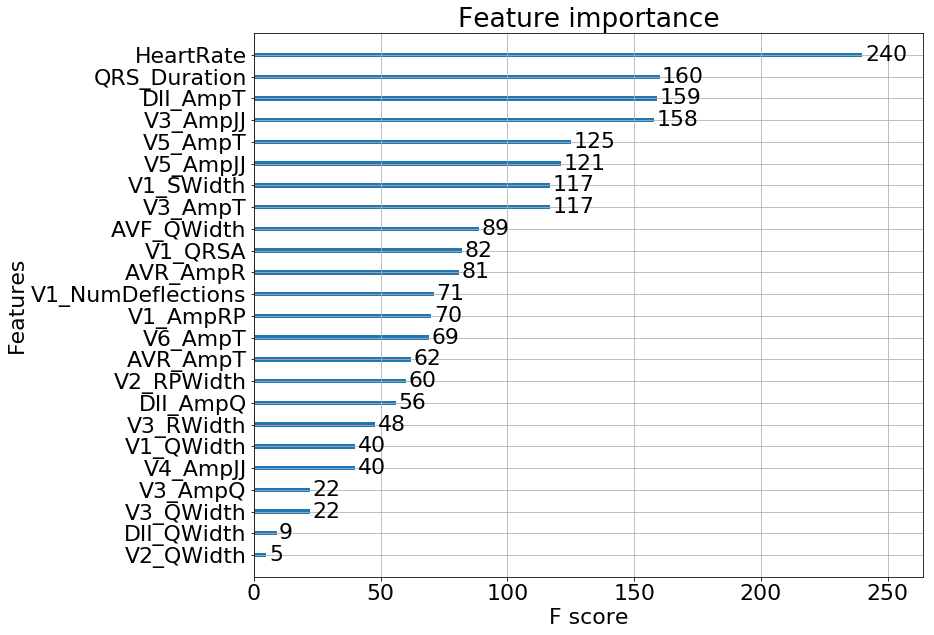

In [60]:
def my_plot_importance(booster, figsize, **kwargs): 
    #from matplotlib.pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

plt.rcParams.update({'font.size': 22})
my_plot_importance(booster=logit_rfe, figsize=[12,10])

Grid Search for XG Boost

In [ ]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'learning_rate':[0.01, 0.1, 0.5, 0.9],
#         'n_estimators':[100,200,500,700]
#         }

# grid_search = GridSearchCV(XGBClassifier(booster='gbtree', objective='multi:softprob'),
#                            param_grid, cv=StratifiedKFold(5, shuffle = True, random_state = 1))

# grid_search.fit(train_rf_X, train_rf_Y)

# print_grid_search(grid_search)

Grid Search for LGBM

In [ ]:
# params = {'boosting_type': 'gbdt',
#           'max_depth' : -1,
#           'objective': 'multiclass',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1}

# gridParams = {
#     'learning_rate': [0.005, 0.01, 0.05, 0.1],
#     'n_estimators': [40, 70, 100, 200],
#     'num_leaves': [6,8,12,16],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['multiclass'],
#     'random_state' : [42], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
#     'max_depth':[5,7,10,12],
#     'feature_fraction':[0.1, 0.5]
#     }


# # Create classifier to use. Note that parameters have to be input manually
# # not as a dict!
# mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
#           objective = 'multiclass',
#           n_jobs = 3,
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight']
#                         )

# # To view the default model params:
# mdl.get_params().keys()

# # Create the grid
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=5,
#                     n_jobs=2)
# # Run the grid
# grid.fit(X_train_scaled, y_train)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)
